# Exploratory Data Analysis (EDA) of Gene Expression Data

### Project Introduction
The objective of this notebook is to perform a comprehensive exploratory data analysis on the TCGA-BRCA RNA-sequencing dataset. The focus here is on understanding the fundamental properties of the data itself. This process helps build intuition about the structure of gene expression data.

--- 
### References

**Data Sources and Platforms**
* [The Cancer Genome Atlas (TCGA)](https://www.cancer.gov/tcga): The primary data used in this analysis originates from the TCGA program, a landmark cancer genomics program that molecularly characterized over 20,000 primary cancer and matched normal samples spanning 33 cancer types

* [UCSC Xena Browser](https://xenabrowser.net/datapages/): The specific clinical and gene expression data files were accessed via the UCSC Xena platform, which provides an intuitive interface for exploring and downloading processed TCGA and other large genomic datasets.

**Survival Libraries**
* [Scikit Survival Docs](https://scikit-survival.readthedocs.io/en/stable/index.html)
* [Lifeline Docs](https://lifelines.readthedocs.io/en/latest/index.html)

---
### Table of Contents

1. [Imports](#imports)
2. [Constants & Data](#constants)
3. ...
8. [Summary](#summary)

---
### 1. Imports <a class="anchor" id="imports"></a>

In [2]:
import os
from pathlib import Path
from typing import Tuple 

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator

from statsmodels.stats.outliers_influence import variance_inflation_factor

---
### 2. Constants & Data Import <a class="anchor" id="constants"></a>


The necessary data files can be accessed and downloaded via the GDC TCGA Breast Cancer (BRCA) portal on the [UCSC Xena Functional Genomics Browser](https://xenabrowser.net/datapages/?cohort=GDC%20TCGA%20Breast%20Cancer%20(BRCA)&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443). The following specific datasets are required:

* **Gene Expression (RNA-Seq)**: 

    *gene expression RNAseq --> STAR - FPKM-UQ*

    The STAR - FPKM-UQ file provides gene expression levels for 58,049 genes. This dataset is derived from RNA sequencing (RNA-Seq) data that has been aligned to the human genome using the STAR (Splicer-Aware Transcriptome Alignment for RNA) aligner.

The notebook expects both tsv files to be placed in the `data/` folder.

In [3]:
ROOT = Path(os.getcwd()).parents[0]

DATA_PATH = os.path.join(ROOT, "data", "TCGA-BRCA.star_fpkm-uq.tsv")

In [4]:
df = pd.read_csv(DATA_PATH, sep="\t", index_col=0).drop_duplicates()

display(df.head())
print(f"Number of genes: {df.shape[0]}")
print(f"Number of samples: {df.shape[1]}")

,TCGA-D8-A146-01A,TCGA-AQ-A0Y5-01A,TCGA-C8-A274-01A,TCGA-BH-A0BD-01A,TCGA-B6-A1KC-01B,TCGA-AC-A62V-01A,TCGA-AO-A0J5-01A,TCGA-BH-A0B1-01A,TCGA-A2-A0YM-01A,TCGA-AO-A03N-01B,...,TCGA-E2-A1IG-01A,TCGA-E9-A1NA-01A,TCGA-D8-A1JP-01A,TCGA-AR-A252-01A,TCGA-D8-A1XL-01A,TCGA-BH-A0EI-01A,TCGA-E2-A1IO-01A,TCGA-E2-A15R-01A,TCGA-B6-A0IP-01A,TCGA-A1-A0SN-01A
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.15,3.767708,2.132741,4.768010,3.049735,3.009311,2.262163,2.929999,4.243105,4.231540,3.126461,...,3.083077,2.463256,3.263365,3.203264,3.653874,4.470745,4.214863,1.175109,5.008083,1.993783
ENSG00000000005.6,1.759454,0.146003,0.000000,1.071763,0.185993,0.308594,0.467071,0.121281,0.124196,0.000000,...,0.038015,0.045024,0.023184,1.922426,0.000000,0.104739,0.224658,0.127501,0.165172,0.015783
ENSG00000000419.13,4.920541,5.284151,5.051694,4.618797,4.852973,5.364065,3.958935,5.171995,4.771500,5.550193,...,4.556411,4.596321,5.213518,4.374831,5.696970,5.234413,4.876325,4.975405,4.569892,6.213147
ENSG00000000457.14,2.612588,2.428544,3.356299,2.680774,2.381671,1.128095,2.787265,2.398214,1.637378,1.876527,...,2.257493,2.141498,3.250295,2.203232,2.196827,2.030407,2.303109,2.895225,2.681697,2.431356
ENSG00000000460.17,1.363395,1.158337,2.458172,2.494236,1.565841,1.249809,1.221939,1.857344,2.197771,1.396050,...,1.223670,1.222805,2.184534,1.291250,1.736778,1.531219,1.123070,1.955015,1.791314,1.716025


Number of genes: 58049
Number of samples: 1226


---
### 3. What does the distribution of gene expression look like? <a class="anchor" id="distributions"></a>

...

In [50]:
df.mean(axis=1)

Ensembl_ID
ENSG00000000003.15    3.518205
ENSG00000000005.6     0.654253
ENSG00000000419.13    5.086979
ENSG00000000457.14    2.319870
ENSG00000000460.17    1.550888
                        ...   
ENSG00000288667.1     0.104356
ENSG00000288669.1     0.001070
ENSG00000288670.1     2.314941
ENSG00000288674.1     0.023102
ENSG00000288675.1     0.395915
Length: 58049, dtype: float64

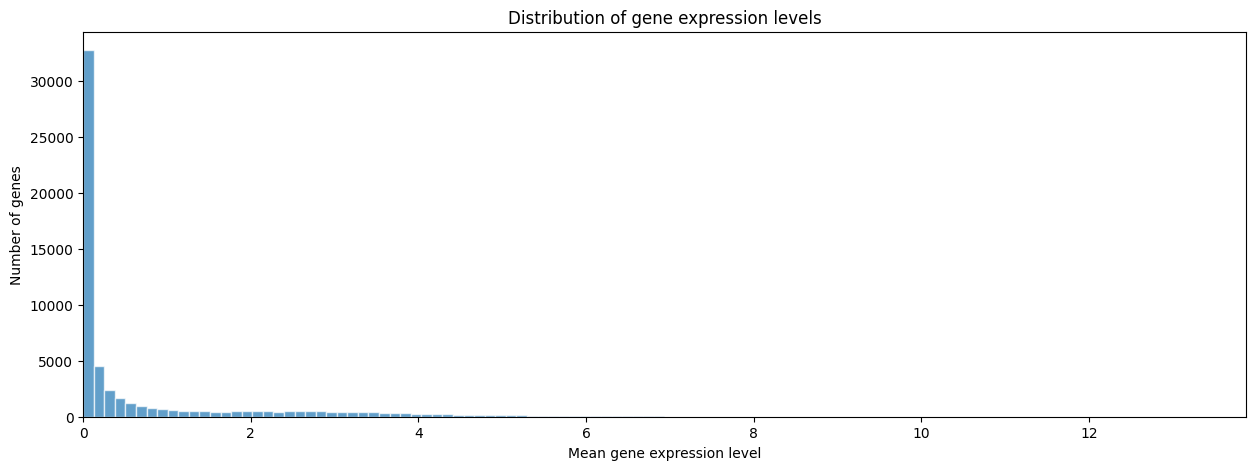

In [51]:
_, ax = plt.subplots(figsize=(15, 5))
df.mean(axis=1).hist(
    bins=100,
    ax=ax,
    edgecolor='white',
    alpha=0.7,
    grid=False
)
plt.title("Distribution of gene expression levels")

plt.xlabel("Mean gene expression level")
plt.ylabel("Number of genes")

plt.xlim(0, df.mean(axis=1).max() * 1.1);

Which genes represent the "housekeeping" genes (those with highest expression)?

In [54]:
df.mean(axis=1).sort_values(ascending=False).head(5)

Ensembl_ID
ENSG00000198938.2    12.608721
ENSG00000198712.1    12.485528
ENSG00000198804.2    12.447667
ENSG00000198886.2    12.325999
ENSG00000210082.2    12.007652
dtype: float64


**Observation**: 
* The genetic expression of this cohort demonstrates a long tail distribution with a low percentage of genes displaying relatively high expression. 
* There is a very large peak near zero, representing the tens of thousands of genes that have very low or no expression in breast tissue.

**Observations**: 
...

---
### 8. Summary

...